# Dogs vs Cats

https://www.kaggle.com/c/dogs-vs-cats-redux-kernels-edition

In [1]:
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import vgg16

print(tf.__version__)
print(tf.executing_eagerly())

2.3.0
True


## Функции загрузки данных

In [3]:
import os
from random import shuffle
from glob import glob

IMG_SIZE = (224, 224)  # размер входного изображения сети

train_files = glob('data/train_sample/*.jpg')
test_files = glob('data/test_sample/*.jpg')

# загружаем входное изображение и предобрабатываем
def load_image(path, target_size=IMG_SIZE):
    img = cv2.imread(path)[...,::-1]
    img = cv2.resize(img, target_size)
    return vgg16.preprocess_input(img)  # предобработка для VGG16

# функция-генератор загрузки обучающих данных с диска
def fit_generator(files, batch_size=32):
    batch_size = min(batch_size, len(files))
    while True:
        shuffle(files)
        for k in range(len(files) // batch_size):
            i = k * batch_size
            j = i + batch_size
            if j > len(files):
                j = - j % len(files)
            x = np.array([load_image(path) for path in files[i:j]])
            y = np.array([1. if os.path.basename(path).startswith('dog') else 0.
                          for path in files[i:j]])
            yield (x, y)

# функция-генератор загрузки тестовых изображений с диска
def predict_generator(files):
    while True:
        for path in files:
            yield np.array([load_image(path)])

## Визуализируем примеры для обучения

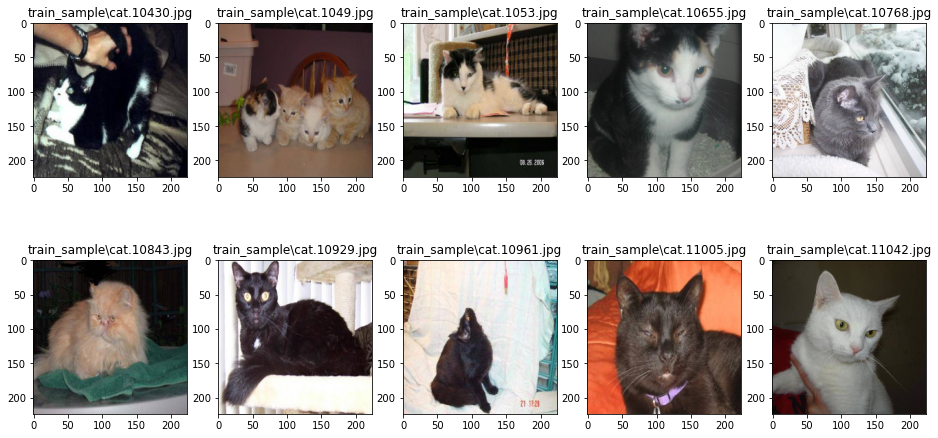

In [4]:
%matplotlib inline
from matplotlib import pyplot as plt
fig = plt.figure(figsize=(16, 8))
for i, path in enumerate(train_files[:10], 1):
    subplot = fig.add_subplot(2, 5, i)
    subplot.set_title('%s' % path.split('/')[-1])
    img = cv2.imread(path)[...,::-1]
    img = cv2.resize(img, IMG_SIZE)
    plt.imshow(img)

### Пример модели из лекции

Обучать эту модель заново я не буду, но оставлю структуру, чтобы использовать в своем коде дальше

#### Загружаем предобученную модель

In [5]:
# base_model - объект класса keras.models.Model (Functional Model)
base_model = vgg16.VGG16(weights='imagenet',
                         include_top=False,
                         input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3))

In [6]:
base_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

#### Добавляем полносвязный слой

In [7]:
# фиксируем все веса предобученной сети
for layer in base_model.layers:
    layer.trainable = False

x = base_model.layers[-5].output
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(1,  # один выход (бинарная классификация)
                          activation='sigmoid',  # функция активации  
                          kernel_regularizer=tf.keras.regularizers.l1(1e-4))(x)

model = tf.keras.Model(inputs=base_model.input, outputs=x, name='dogs_vs_cats')

#### Выводим архитектуру модели

In [8]:
model.summary()

Model: "dogs_vs_cats"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)      

#### Компилируем модель и запускаем обучение

In [13]:
model.compile(optimizer='adam', 
              loss='binary_crossentropy',  # функция потерь binary_crossentropy (log loss
              metrics=['accuracy'])

In [ ]:
val_samples = 5  # число изображений в валидационной выборке

shuffle(train_files)  # перемешиваем обучающую выборку
validation_data = next(fit_generator(train_files[:val_samples], val_samples))
train_data = fit_generator(train_files[val_samples:])  # данные читаем функцией-генератором

# запускаем процесс обучения
model.fit(train_data,
          steps_per_epoch=10,  # число вызовов генератора за эпоху
          epochs=100,  # число эпох обучения
          validation_data=validation_data)

### Новая модель. Попытка 1 

Добавим к исходной базовой модели слои с нормализацией.

In [5]:
from tensorflow import keras
from keras.layers import BatchNormalization

In [6]:
# Вспомогательные функции
def replace_intermediate_layer_in_keras(model, layer_id, new_layer):
    '''Замена слоя в модели по его id на указанный'''
    from keras.models import Model

    layers = [l for l in model.layers]

    x = layers[0].output
    for i in range(1, len(layers)):
        if i == layer_id:
            x = new_layer(x)
        else:
            x = layers[i](x)

    new_model = Model(inputs=layers[0].input, outputs=x)
    return new_model

def insert_intermediate_layer_in_keras(model, layer_id, new_layer):
    '''Вставка нового слоя, после слоя, указанного по id'''
    from keras.models import Model

    layers = [l for l in model.layers]

    x = layers[0].output
    for i in range(1, len(layers)):
        if i == layer_id:
            x = new_layer(x)
        x = layers[i](x)

    new_model = Model(inputs=layers[0].input, outputs=x)
    return new_model

In [52]:
upd_model = base_model
upd_model = insert_intermediate_layer_in_keras(upd_model, 4, BatchNormalization())
upd_model = insert_intermediate_layer_in_keras(upd_model, 8, BatchNormalization())
upd_model = insert_intermediate_layer_in_keras(upd_model, 13, BatchNormalization())
upd_model = insert_intermediate_layer_in_keras(upd_model, 18, BatchNormalization())
upd_model = insert_intermediate_layer_in_keras(upd_model, 23, BatchNormalization())
print(upd_model.summary())


Model: "functional_27"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
batch_normalization_20 (Batc (None, 112, 112, 64)      256       
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)   

Так же как и в примере добавим полносвязный слой в конце, отвечащий за бинарную классификацию

In [53]:

x = upd_model.layers[-5].output
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(1,  # один выход (бинарная классификация)
                          activation='sigmoid',  # функция активации  
                          kernel_regularizer=tf.keras.regularizers.l1(1e-4))(x)

upd_model = tf.keras.Model(inputs=upd_model.input, outputs=x, name='dogs_vs_cats')

In [54]:
upd_model.summary()

Model: "dogs_vs_cats"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
batch_normalization_20 (Batc (None, 112, 112, 64)      256       
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)    

### Обучение на полном выборке данных

In [57]:
train_files_full = glob('data/dogs-vs-cats-redux-kernels-edition/train/*.jpg')
test_files_full = glob('data/dogs-vs-cats-redux-kernels-edition/test/*.jpg')

In [61]:
val_samples = round(0.2*len(train_files_full)) 

shuffle(train_files_full)  
validation_data_full = next(fit_generator(train_files_full[:val_samples], val_samples))
train_data_full = fit_generator(train_files_full[val_samples:])  

In [63]:
upd_model.fit(train_data_full,
          steps_per_epoch=10, 
          epochs=100, 
          validation_data=validation_data_full)

Epoch 1/100
10/10 [==============================] - 149s 15s/step - loss: 1.3718 - accuracy: 0.8219 - val_loss: 2.4918 - val_accuracy: 0.6000
Epoch 2/100
10/10 [==============================] - 149s 15s/step - loss: 1.1223 - accuracy: 0.8625 - val_loss: 1.8734 - val_accuracy: 0.6000
Epoch 3/100
10/10 [==============================] - 148s 15s/step - loss: 1.6647 - accuracy: 0.8219 - val_loss: 1.6327 - val_accuracy: 0.8000
Epoch 4/100
10/10 [==============================] - 149s 15s/step - loss: 1.5940 - accuracy: 0.8594 - val_loss: 4.6794 - val_accuracy: 0.4000
Epoch 5/100
10/10 [==============================] - 148s 15s/step - loss: 1.4733 - accuracy: 0.8562 - val_loss: 0.7168 - val_accuracy: 0.8000
Epoch 6/100
10/10 [==============================] - 148s 15s/step - loss: 0.8451 - accuracy: 0.9031 - val_loss: 0.4168 - val_accuracy: 0.8000
Epoch 7/100
10/10 [==============================] - 147s 15s/step - loss: 1.2929 - accuracy: 0.8938 - val_loss: 0.3857 - val_accuracy: 0.8000

Epoch 58/100
10/10 [==============================] - 142s 14s/step - loss: 1.0475 - accuracy: 0.9094 - val_loss: 1.2373 - val_accuracy: 0.8000
Epoch 59/100
10/10 [==============================] - 143s 14s/step - loss: 1.0453 - accuracy: 0.9344 - val_loss: 2.3481 - val_accuracy: 0.8000
Epoch 60/100
10/10 [==============================] - 142s 14s/step - loss: 1.1415 - accuracy: 0.9125 - val_loss: 3.5527 - val_accuracy: 0.8000
Epoch 61/100
10/10 [==============================] - 143s 14s/step - loss: 1.0116 - accuracy: 0.9312 - val_loss: 3.0833 - val_accuracy: 0.8000
Epoch 62/100
10/10 [==============================] - 143s 14s/step - loss: 0.8598 - accuracy: 0.9250 - val_loss: 1.6342 - val_accuracy: 0.8000
Epoch 63/100
10/10 [==============================] - 144s 14s/step - loss: 0.5001 - accuracy: 0.9594 - val_loss: 2.4658 - val_accuracy: 0.8000
Epoch 64/100
10/10 [==============================] - 143s 14s/step - loss: 0.3942 - accuracy: 0.9844 - val_loss: 2.6793 - val_accuracy:

In [64]:
upd_model.save('upd-cats-dogs-vgg16.hdf5')

Несколько последних эпох модель показывает достаточно низкий val_loss < 0.2 и подозрительную val_accuracy = 1.0. Возможно, модель переобучилась. Посмотрим на её результат на отложенных тестовых данных. 

In [65]:
test_pred_full = upd_model.predict(
    predict_generator(test_files_full), steps=len(test_files_full))

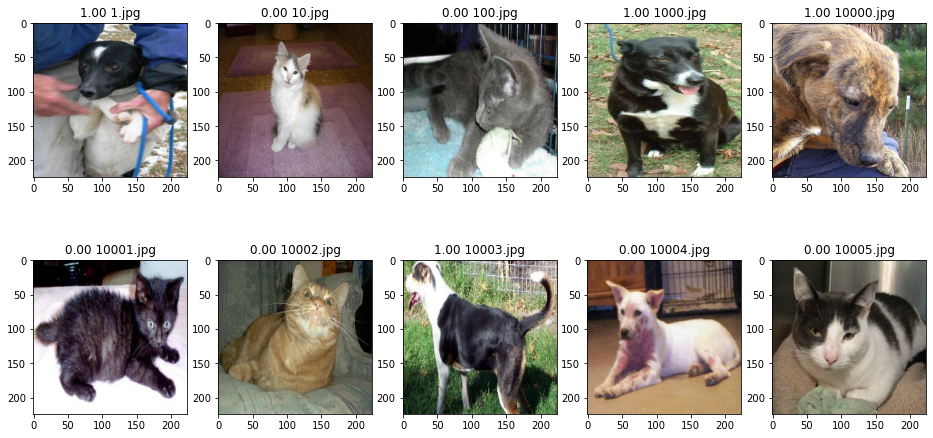

In [66]:
fig = plt.figure(figsize=(16, 8))
for i, (path, score) in enumerate(zip(test_files_full[:10], test_pred_full[:10]), 1):
    subplot = fig.add_subplot(2, 5, i)
    subplot.set_title('%.2f %s' % (score, os.path.basename(path)))
    img = cv2.imread(path)[...,::-1]
    img = cv2.resize(img, IMG_SIZE)
    subplot.imshow(img)

In [67]:
import re

with open('submit.txt', 'w') as dst:
    dst.write('id,label\n')
    for path, score in zip(test_files_full, test_pred_full):
        dst.write('%s,%f\n' % (re.search('(\d+).jpg$', path).group(1), score))

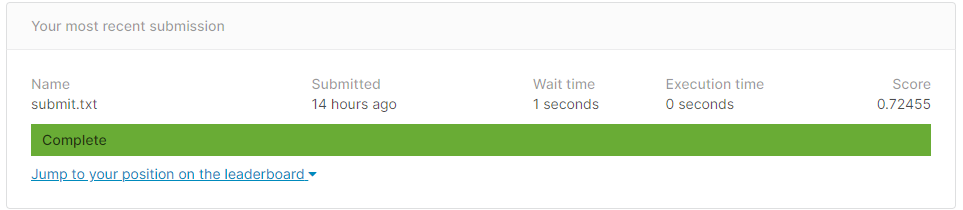

In [16]:
from IPython.display import Image
Image(filename='images/upd_model_score.jpg') 

Результат средний, надо пробовать другие варианты

### Модель 2

Пробую чуть более простую модель, с меньшим количеством сверточных слоев

In [7]:
from keras.models import Sequential
from keras.layers import Dense,Flatten, Dropout
from keras.layers import Conv2D,MaxPooling2D
from keras import regularizers
from keras import optimizers

In [23]:
model_new = tf.keras.models.Sequential([
    
    #Conv layer 1
    tf.keras.layers.Conv2D(64, (5, 5), activation='relu', 
                            kernel_regularizer=regularizers.l2(0.0001), input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3)),
    tf.keras.layers.MaxPool2D(2, 2),
    #Conv layer 2
    tf.keras.layers.Conv2D(128, (5, 5), kernel_regularizer=regularizers.l2(0.0001), activation='relu'),
    tf.keras.layers.MaxPool2D(2, 2),
    #Conv layer 3
    tf.keras.layers.Conv2D(128, (5, 5), kernel_regularizer=regularizers.l2(0.0001), activation='relu'),
    tf.keras.layers.MaxPool2D(2, 2),
    #Conv layer 4
    tf.keras.layers.Conv2D(128, (5, 5), kernel_regularizer=regularizers.l2(0.0001), activation='relu'),
    tf.keras.layers.MaxPool2D(2, 2),
    #Flatten
    tf.keras.layers.Flatten(),
    #Fully Connected layer
    tf.keras.layers.Dense(256, activation='relu'),
    #Dropout
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1, activation='sigmoid')
    
])

opt = optimizers.Adam(learning_rate=0.0001)
model_new.compile(loss="binary_crossentropy",
              optimizer=opt, metrics=["accuracy"])

In [24]:
model_new.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 220, 220, 64)      4864      
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 110, 110, 64)      0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 106, 106, 128)     204928    
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 53, 53, 128)       0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 49, 49, 128)       409728    
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 24, 24, 128)       0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 20, 20, 128)      

#### Обучение

In [9]:
val_samples = round(0.2*len(train_files_full))  

shuffle(train_files_full)  
validation_data_full = next(fit_generator(train_files_full[:val_samples], val_samples))
train_data_full = fit_generator(train_files_full[val_samples:])  

In [30]:
# добавлю коллбэки, чтобы уменьшить вероятность переобучения
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', 
                                            patience=2, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

earlystop = EarlyStopping(patience=10)

In [32]:
model_new.fit(
    train_data_full,
    epochs=20,
    steps_per_epoch=500,
    verbose=1,
    validation_data=validation_data_full
    callbacks = [earlystop, learning_rate_reduction]
)

Epoch 1/20
500/500 [==============================] - 4363s 9s/step - loss: 0.6798 - accuracy: 0.6263 - val_loss: 0.6087 - val_accuracy: 0.6968
Epoch 2/20
500/500 [==============================] - 4871s 10s/step - loss: 0.5998 - accuracy: 0.7033 - val_loss: 0.5454 - val_accuracy: 0.7456
Epoch 3/20
500/500 [==============================] - 4457s 9s/step - loss: 0.5185 - accuracy: 0.7653 - val_loss: 0.5159 - val_accuracy: 0.7670
Epoch 4/20
500/500 [==============================] - 3971s 8s/step - loss: 0.4630 - accuracy: 0.8012 - val_loss: 0.4641 - val_accuracy: 0.7950
Epoch 5/20
500/500 [==============================] - 3971s 8s/step - loss: 0.4114 - accuracy: 0.8323 - val_loss: 0.4305 - val_accuracy: 0.8314
Epoch 6/20
500/500 [==============================] - 3972s 8s/step - loss: 0.3571 - accuracy: 0.8622 - val_loss: 0.3773 - val_accuracy: 0.8484
Epoch 7/20
500/500 [==============================] - 3970s 8s/step - loss: 0.2891 - accuracy: 0.8927 - val_loss: 0.3792 - val_accuracy

#### Проверка на тестовых данных

In [38]:
test_pred_full = model_new.predict(
    predict_generator(test_files_full), steps=len(test_files_full))

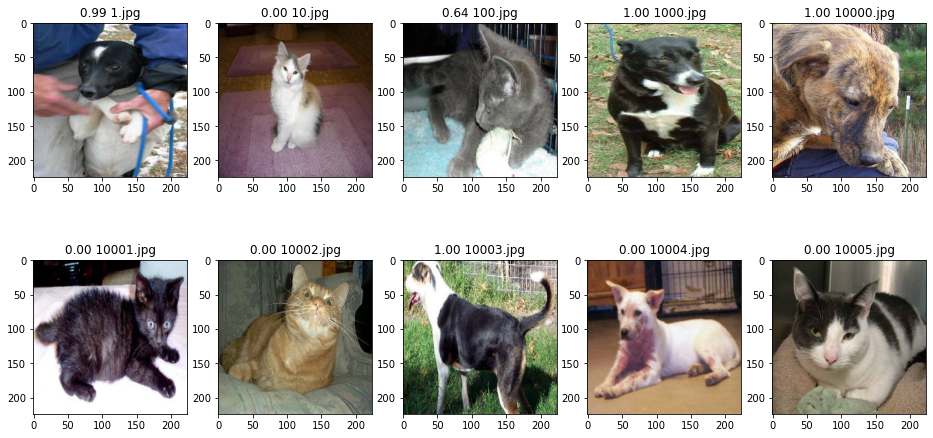

In [39]:
fig = plt.figure(figsize=(16, 8))
for i, (path, score) in enumerate(zip(test_files_full[:10], test_pred_full[:10]), 1):
    subplot = fig.add_subplot(2, 5, i)
    subplot.set_title('%.2f %s' % (score, os.path.basename(path)))
    img = cv2.imread(path)[...,::-1]
    img = cv2.resize(img, IMG_SIZE)
    subplot.imshow(img)

In [40]:
with open('submit_model_new.txt', 'w') as dst:
    dst.write('id,label\n')
    for path, score in zip(test_files_full, test_pred_full):
        dst.write('%s,%f\n' % (re.search('(\d+).jpg$', path).group(1), score))

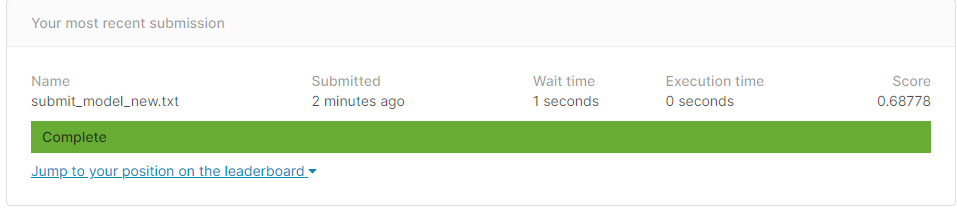

In [34]:
Image('images/new_model_score.jpg')

Интересно, что более простая модель дала незначительно, но все же лучший результат, чем предыдущий более многослойный вариант. Попробую расширить и улучшить эту архитектуру 

### Модель 3

In [13]:
model = tf.keras.models.Sequential([
    #Conv layer 1
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPool2D(2, 2),
    #Conv layer 2
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPool2D(2, 2),
    #Conv layer 3
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPool2D(2, 2),
    #Conv layer 4
    tf.keras.layers.Conv2D(256, (3, 3), activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPool2D(2, 2),
    #Conv layer 5
    tf.keras.layers.Conv2D(256, (3, 3), activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPool2D(2, 2),
    #Flatten
    tf.keras.layers.Flatten(),
    #Fully Connected layer
    tf.keras.layers.Dense(1024, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    tf.keras.layers.BatchNormalization(),
    #Dropout
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1, activation='sigmoid', kernel_regularizer=regularizers.l2(0.0001))
    
])

In [14]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_10 (Conv2D)           (None, 222, 222, 32)      896       
_________________________________________________________________
batch_normalization_11 (Batc (None, 222, 222, 32)      128       
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 111, 111, 32)      0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 109, 109, 64)      18496     
_________________________________________________________________
batch_normalization_12 (Batc (None, 109, 109, 64)      256       
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 54, 54, 64)        0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 52, 52, 128)      

In [16]:
from keras.optimizers import RMSprop

In [17]:
model.compile(optimizer=RMSprop(lr=0.001), loss='binary_crossentropy', metrics=['acc'])

In [10]:
my_callback_es = EarlyStopping(monitor='val_acc', patience=5)
my_callback_rlr = ReduceLROnPlateau(monitor='val_acc', patience=2, factor=0.5, min_lr=0.00001, verbose=1)

In [21]:
history = model.fit_generator(
    train_data_full, 
    steps_per_epoch = 100,
    epochs = 100,
    verbose = 1,
    validation_data = validation_data_full,
    callbacks=[my_callback_es, my_callback_rlr]
)

Epoch 1/100
100/100 [==============================] - 380s 4s/step - loss: 2.4390 - acc: 0.5781 - val_loss: 2.5332 - val_acc: 0.5412
Epoch 2/100
100/100 [==============================] - 380s 4s/step - loss: 1.4545 - acc: 0.6047 - val_loss: 1.4997 - val_acc: 0.6464
Epoch 3/100
100/100 [==============================] - 378s 4s/step - loss: 1.0187 - acc: 0.6447 - val_loss: 0.9554 - val_acc: 0.6710
Epoch 4/100
100/100 [==============================] - 379s 4s/step - loss: 0.8338 - acc: 0.6869 - val_loss: 1.0673 - val_acc: 0.6444
Epoch 5/100
100/100 [==============================] - 381s 4s/step - loss: 0.7651 - acc: 0.7016 - val_loss: 0.7182 - val_acc: 0.7136
Epoch 6/100
100/100 [==============================] - 379s 4s/step - loss: 0.6959 - acc: 0.7312 - val_loss: 0.6934 - val_acc: 0.7276
Epoch 7/100
100/100 [==============================] - 376s 4s/step - loss: 0.6668 - acc: 0.7359 - val_loss: 0.6517 - val_acc: 0.7598
Epoch 8/100
100/100 [==============================] - 376s 4s

In [22]:
model.save('model3-cats-dogs-vgg16.hdf5')

Здесь коллбэки прервали обучение относительно рано, целевой показатель val_accuraсy несколько последних эпох изменяется незначительно, даже с учетом уменьшения learning rate за счет другого коллбэка. Проверим, достаточно ли нам такого качества в результате

In [24]:
test_pred = model.predict(
    predict_generator(test_files_full), steps=len(test_files_full))

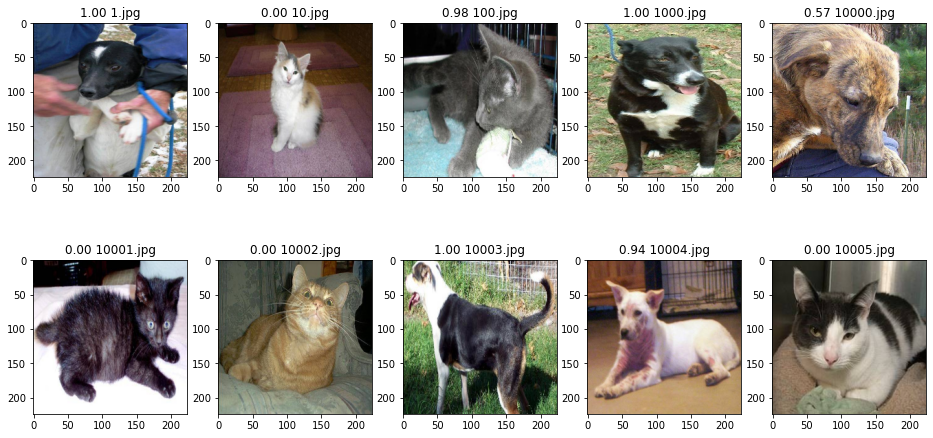

In [26]:
fig = plt.figure(figsize=(16, 8))
for i, (path, score) in enumerate(zip(test_files_full[:10], test_pred[:10]), 1):
    subplot = fig.add_subplot(2, 5, i)
    subplot.set_title('%.2f %s' % (score, os.path.basename(path)))
    img = cv2.imread(path)[...,::-1]
    img = cv2.resize(img, IMG_SIZE)
    subplot.imshow(img)

In [28]:
with open('submit-3.txt', 'w') as dst:
    dst.write('id,label\n')
    for path, score in zip(test_files_full, test_pred):
        dst.write('%s,%f\n' % (re.search('(\d+).jpg$', path).group(1), score))

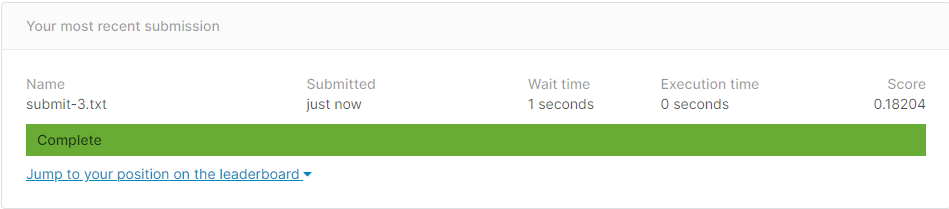

In [30]:
Image('images/model_3_score.jpg')

Да, это достаточный результат, на этом можно остановиться